In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import fftconvolve
from numpy.fft import fft2, ifft2, fftshift, ifftshift

In [5]:
# PSF
def moffat(x, y, m, a):
    """
    (1+(r/a)^2)^-m
    """
    r = np.sqrt(x ** 2 + y ** 2)
    return (1 + (r / a) ** 2) ** (-m)


# Galaxy
def sersic(x, y, k, n):
    """
    exp[-kr^(1/n)]
    """
    r = np.sqrt(x ** 2 + y ** 2)
    return np.exp(-k * r ** (1 / n))

In [4]:
def wiener_deconvolution(img, psf, K):
    psf_fft = fft2(np.flip(psf, (0, 1)), s=img.shape)
    img_fft = fft2(img)
    result = ifft2((np.conj(psf_fft) * img_fft) / (psf_fft * np.conj(psf_fft) + K))
    result = ifftshift(result)
    return np.real(result)

In [6]:
def gaussian_weight(x, y, a, b):
    weight = np.exp(-0.5 * ((x / a) ** 2 + (y / b) ** 2))
    return weight / weight.sum()

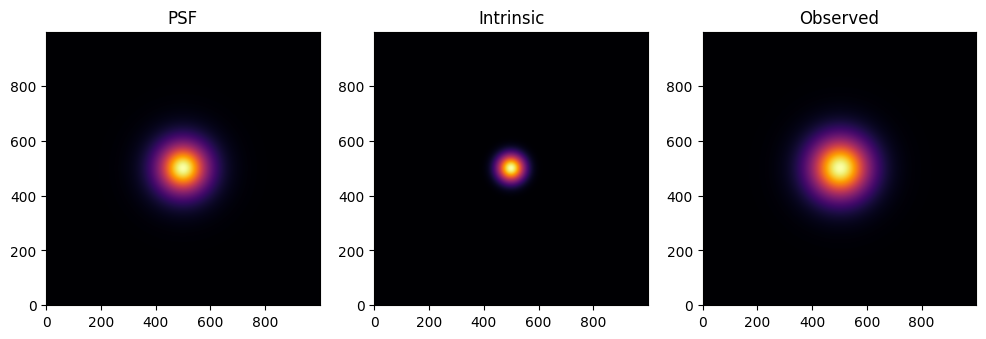

In [8]:
N = 1000
x = np.linspace(-32, 32, N)
y = np.linspace(-32, 32, N)
X, Y = np.meshgrid(x, y)

image_psf = moffat(X, Y, m=3.5, a=10)
image_intrinsic = sersic(X, Y, k=0.1, n=1/2)

image = fftconvolve(image_intrinsic, image_psf, mode="same")
noise = np.random.normal(0, 3, size=image.shape)
# image += noise
fig, axs = plt.subplots(1, 3, figsize=(12, 8))

im0 =axs[0].imshow(image_psf, cmap="inferno", origin="lower")
axs[0].set_title("PSF")

im1 = axs[1].imshow(image_intrinsic, cmap="inferno", origin="lower")
axs[1].set_title("Intrinsic")

im1 = axs[2].imshow(image, cmap="inferno", origin="lower")
axs[2].set_title("Observed")
plt.show()

In [9]:
weight = gaussian_weight(X, Y, 25, 25)

true_F = np.sum(weight * image_intrinsic)
print(true_F)

weight_rescale = wiener_deconvolution(weight, image_psf, 0)

measured_F = np.sum(weight_rescale * image)

print(measured_F)

0.012403731989466038
0.012397277424795128
